# Why do IRL and IRR files have similar, if not the same, insertions?

Could be because the transposon and adapter tags were incorrect from the IAS pipeline, and on top of that they were incorrectly used in cutadapt (not using reverse complement). I have output from bowtie2 that summarizes the mapping results and will need to dynamically parse the output file for mapping qualities

In [2]:
from IPython.display import display
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn.objects as so
from scipy.stats import ranksums

In [5]:
# bowtie_dir = Path("/project/cs-myers/MathewF/projects/Laura-SB-Analysis/NetCIS/toy-data/2020_SB-bowtie/")
bowtie_dir = Path("/research/labs/immunology/rogerslm/m277102/projects/NetCIS/2020_SB/all_files-bowtie")

In [6]:
list_df = []
for file in bowtie_dir.iterdir():
    tumor_model, sample_id, tumor_tmp = file.name.split("-")
    tissue_type, lib_tmp = tumor_tmp.split("_")
    library = lib_tmp.split(".")[0]
    tmp_dict = {"tumor_model": tumor_model, "sample_id": sample_id, "tissue_type": tissue_type, "library": library}
    with open(file) as f:
        for line in f:
            line = line.strip()
            if line.find("reads; of these:") != -1:
                tmp_dict["total_reads"] = [int(line.split(" ")[0])]
            elif line.find("were paired; of these:") != -1:
                tmp_dict["paired_reads"] = [int(line.split(" ")[0])]
            elif line.find("aligned concordantly 0 times") != -1:
                tmp_dict["concordant_reads-0"] = [int(line.split(" ")[0])]
            elif line.find("aligned concordantly exactly 1 time") != -1:
                tmp_dict["concordant_reads-1"] = [int(line.split(" ")[0])]
            elif line.find("aligned concordantly >1 times") != -1:
                tmp_dict["concordant_reads->1"] = [int(line.split(" ")[0])]
            elif line.find("aligned discordantly 1 time") != -1:
                tmp_dict["discordant_reads-1"] = [int(line.split(" ")[0])]
            else:
                pass
    # there should be 10 keys in tmp_dict if all the above lines were parsed successfully
    if len(tmp_dict) != 10:
        print("hey something's wrong here")
        display(tmp_dict)
    tmp_df = pd.DataFrame.from_dict(tmp_dict)
    list_df.append(tmp_df)
bowtie_df = pd.concat(list_df, ignore_index=True)
bowtie_df["aligned_reads"] = bowtie_df["concordant_reads-1"] + bowtie_df["concordant_reads->1"] + bowtie_df["discordant_reads-1"]
display(bowtie_df)

,tumor_model,sample_id,tissue_type,library,total_reads,paired_reads,concordant_reads-0,concordant_reads-1,concordant_reads->1,discordant_reads-1,aligned_reads
0,EL4,48_4,LT,IRR,950569,950404,776343,159140,14921,2667,176728
1,B16,1_1,RT,IRR,1529,1523,1104,369,50,3,422
2,B16,474_5,S,IRL,2413,2413,2347,21,45,1,67
3,B16,474_2,S,IRR,2244,2244,2008,198,38,0,236
4,B16,516_2,RT,IRL,1356227,1356227,1351317,1749,3161,13,4923
...,...,...,...,...,...,...,...,...,...,...,...
619,EL4,28_3,LT,IRR,1017161,1017157,654492,299011,63654,6876,369541
620,EL4,28_3,S,IRL,2043035,2043035,2024564,6955,11516,87,18558
621,B16PD1,533_2,LT,IRR,1267,1265,939,259,67,6,332
622,B16,484_2,RT,IRR,693,691,533,126,32,4,162


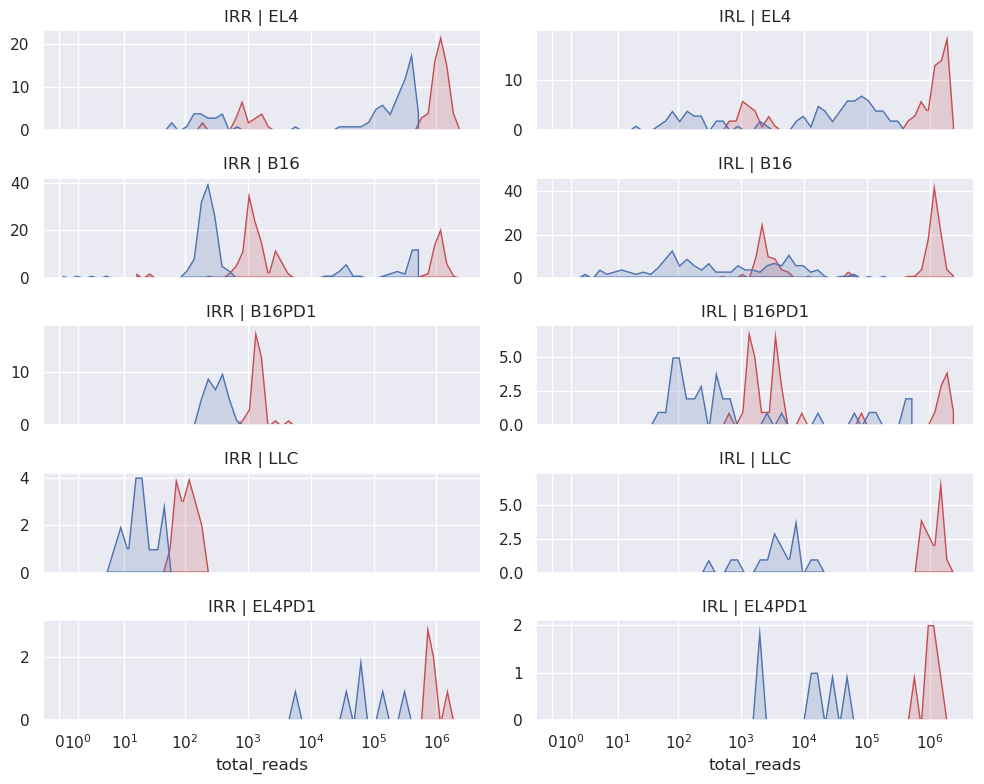

In [18]:
# check difference between IRR and IRL aligned reads
def tumor_lib_diff(df, feature1, feature2):
    g = (
        so.Plot(df)
        .add(so.Area(color="r"), so.Hist(bins=50), x=df[feature1])
        .add(so.Area(), so.Hist(bins=50), x=df[feature2])
        # .add(so.Line(), so.KDE(cut=0))
        .facet(col="library", row="tumor_model")
        .scale(x="symlog")
        .share(y=False)
        .layout(size=(10,8))
    )
    g.show()

    # irl = bowtie_df[bowtie_df["library"] == "IRL"]
    # irr = bowtie_df[bowtie_df["library"] == "IRR"]
    
    # rs1 = ranksums(irl[feature], irr[feature], alternative="two-sided", nan_policy="raise")
    # print(f"ranksums two-sided pval: {rs1[1]}")
    # rs2 = ranksums(irl[feature], irr[feature], alternative="less", nan_policy="raise")
    # print(f"ranksums irl < irr pval: {rs2[1]}")
    # rs3 = ranksums(irl[feature], irr[feature], alternative="greater", nan_policy="raise")
    # print(f"ranksums irl > irr pval: {rs3[1]}")
    
tumor_lib_diff(bowtie_df, "total_reads", "aligned_reads")
    

In [ ]:
tumor_lib_diff(bowtie_df, "concordant_reads-1")

In [ ]:
tumor_lib_diff(bowtie_df, "concordant_reads->1")

In [ ]:
tumor_lib_diff(bowtie_df, "discordant_reads-1")

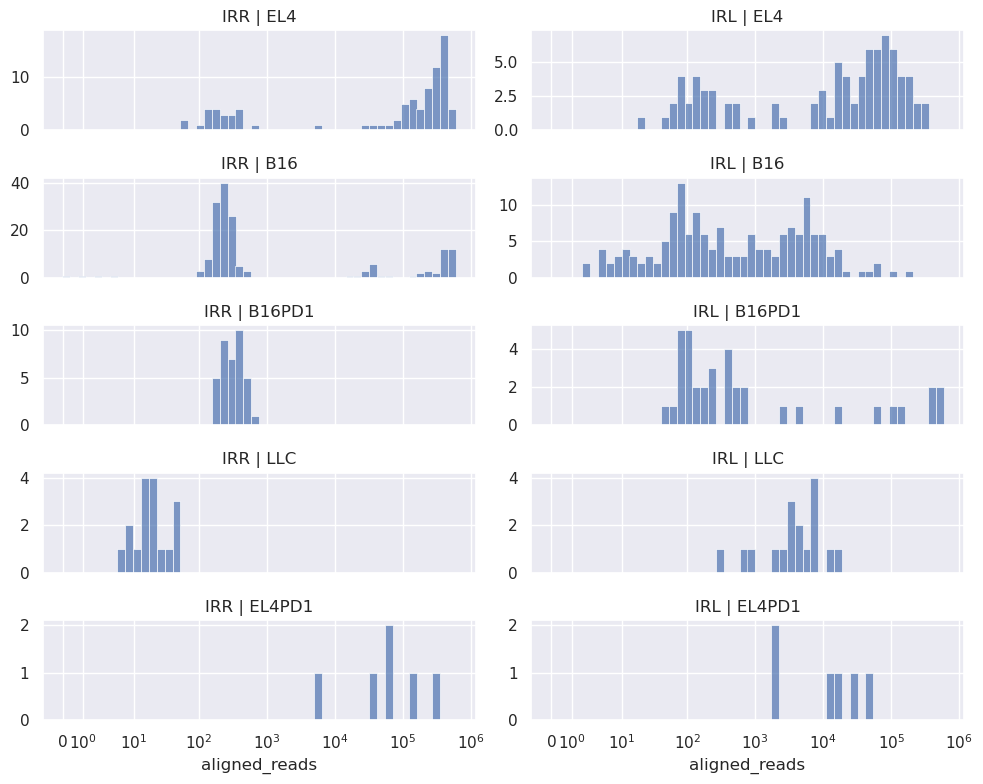

ranksums two-sided pval: 0.02034965376201288
ranksums irl < irr pval: 0.01017482688100644
ranksums irl > irr pval: 0.9898251731189935


In [149]:
tumor_lib_diff(bowtie_df, "aligned_reads")

In [98]:
# can also check stats of the bam file with:
# samtools flagstat <file.bam>
# samtools idxstats <file.bam>

# What happens when TA site is chosen at the same location of the insertion?

Previously saw the same insertions from both irl and irr files. 

Possible bug in code?

In [24]:
from pathlib import Path
from multiprocessing import Pool

import pysam
import pandas as pd
import numpy as np

In [81]:
chr_dict = {
    "NC_000067.7": "chr1",
    "NC_000068.8": "chr2",
    "NC_000069.7": "chr3",
    "NC_000070.7": "chr4",
    "NC_000071.7": "chr5",
    "NC_000072.7": "chr6",
    "NC_000073.7": "chr7",
    "NC_000074.7": "chr8",
    "NC_000075.7": "chr9",
    "NC_000076.7": "chr10",
    "NC_000077.7": "chr11",
    "NC_000078.7": "chr12",
    "NC_000079.7": "chr13",
    "NC_000080.7": "chr14",
    "NC_000081.7": "chr15",
    "NC_000082.7": "chr16",
    "NC_000083.7": "chr17",
    "NC_000084.7": "chr18",
    "NC_000085.7": "chr19",
    "NC_000086.8": "chrX",
    "NC_000087.8": "chrY",
    "NC_005089.1": "chrM",
}


def convert_mapq(x):
    return np.power(10, x/(-10))

def get_insertion_properties(insertion, chrdict, TA_type) -> pd.DataFrame:
    """
    record the insertions stats (direction, +/-, and all that)
    NOTE: here is where additional statistics and or properties for each insertion site can be added
    """
    tmp = insertion.get_forward_sequence()
    res = {
        "chr": [chrdict[insertion.reference_name]],
        "pos": [insertion.reference_start],  # 0-based left most coordinate
        "strand +": [insertion.is_forward],
        "ref length": [insertion.reference_length],
        "query length": [
            insertion.infer_query_length()
        ],  # does not include hard-clipped bases
        "read length": [
            insertion.infer_read_length()
        ],  # does include hard-clipped bases. should be equal to len(query_sequence)
        "mapping quality": [insertion.mapping_quality],  # MAPQ: MAPping Quality.
        # MAPQ equals −10 log10 Pr{mapping position is wrong}, rounded to the nearest integer.
        # A value 255 indicates that the mapping quality is not available.
        # otherwise, the higher the number, the more confident of the quality of the mapping
        # see solution for x in wolfram
        #       254 = -10 * log10(x)
        #       11 = -10 * log10(x)
        "read name": [insertion.query_name],
        "TA_location": [TA_type],
        "read": [tmp[:4] + "-" + tmp[-4:]],
    }
    res = pd.DataFrame.from_dict(res)
    return res

def read_is_quality(read, mapq_thres, chr_dict) -> bool:
    # that is paired
    if not read.is_paired:
        return False

    # this is mapped
    if not read.is_mapped:
        return False

    # has a contig (chromosome) is the predefined dict
    if read.reference_name not in chr_dict.keys():
        return False
    
    # read must have a high quality mapping score
    if convert_mapq(read.mapping_quality) > mapq_thres:
        return False

    # check if read is forward (+) or reverse (-), then see if 'TA' is present with respects to IRR/IRL orientation
    # TODO: when everything else is set, compare IRL and IRR insertions if we assume the TA is at the beginning of the forward seq
    
    # TODO: create dataframe for each insertion that are quality, but don't have a TA where we expect
    # and visualize proportion of TA and non-TA
    
    # if read.is_forward:  # forward 5' - 3'
    #     if read.get_forward_sequence()[:2] == "TA":
    #         return True
    # elif not read.is_forward:
    #     if read.get_forward_sequence()[-2:] == "TA":
    #         return True
    # else:
    #     return False
    return True
        



def process_bam(file, mapq_thres, chr_dict) -> pd.DataFrame | None:
    """
    Filter out low quality insertions
    This only can run on paired read sequencing data
    """

    bam = pysam.AlignmentFile(file, "rb")
    insertions = []
    for read1 in bam.fetch():  # multiple_iterators=True
        # only look at read 1
        if not read1.is_read1:
            continue
        
        # must have a mate read that is mapped for .mate() to return properly
        if read1.mate_is_unmapped or (not read1.is_paired):
            continue
        
        # read 1 and read 2 must map to the same contig
        read2 = bam.mate(read1)
        if read1.reference_name != read2.reference_name:
            continue
        
        # if the read1 is a quality read, then get the insertions properties
        if read_is_quality(read1, mapq_thres, chr_dict):
            # check if read is forward (+) or reverse (-), then see if 'TA' is present with respects to IRR/IRL orientation
            if read1.get_forward_sequence()[:2] == "TA":
                ta_type = "first"
            elif read1.get_forward_sequence()[-2:] == "TA":
                ta_type = "last"
            else:
                ta_type = "none"
            insert_properties = get_insertion_properties(read1, chr_dict, ta_type)
            insertions.append(insert_properties)
                
        # check if read 2 (the mate read) is quality and can be used for insertion properties
        else:  
            if read_is_quality(read2, mapq_thres, chr_dict):
                if read2.get_forward_sequence()[:2] == "TA":
                    ta_type = "first"
                elif read2.get_forward_sequence()[-2:] == "TA":
                    ta_type = "last"
                else:
                    ta_type = "none"
                insert_properties = get_insertion_properties(read2, chr_dict, ta_type)
                insertions.append(insert_properties)
    bam.close()

    # check if there were any inseritons at all to avoid errors from pandas.concat()
    if len(insertions) == 0:
        return None
    else:
        return pd.concat(insertions, axis=0).reset_index(drop=True)



In [82]:
cwd = Path.cwd().parent



output_prefix = "toy-data/2020_SB"
npara = 2
input_files = cwd / "toy-data/input.tsv"
thres = 0.05

bam_dir = Path(cwd / (output_prefix + "-bam"))

insertions_dir = Path(cwd / (output_prefix + "-insertions"))
insertions_dir.mkdir(parents=True, exist_ok=True)

files_df = pd.read_csv(input_files, sep="\t", header=None)
iter_args = [ (row[1], bam_dir, insertions_dir, thres) for row in files_df.iterrows() ]
# with Pool(npara) as p:
#     [ x for x in p.imap_unordered(process_bam_helper, iter_args) ]


# def process_bam_helper(iter_args) -> None:
# for args in iter_args:


In [83]:
row, bam_dir, insertions_dir, thres = iter_args[0]
mysample = row[0]
irl_bam = bam_dir / (mysample + "_IRL.bam")
irr_bam = bam_dir / (mysample + "_IRR.bam")


# find quality insertion in IRR and IRL libraries and convert them to single insertion site format
inserts_irl_df = process_bam(file=irl_bam, mapq_thres=thres, chr_dict=chr_dict)
if (inserts_irl_df is not None):  # if no insertions present, process_bam returns None
    inserts_irl_df["seq library"] = "IRL"
    # set transposon promoter orientation depending on sequencing library
    # For IRR: + if forward, - if not. For IRL this is reversed. Also, make the orientations easier to read (+/-)
    inserts_irl_df["tpn promoter orient +"] = ~inserts_irl_df["strand +"]
    inserts_irl_df["strand"] = np.where(inserts_irl_df["strand +"], "+", "-")
    inserts_irl_df["tpn promoter orient"] = np.where(inserts_irl_df["tpn promoter orient +"], "+", "-")
    inserts_irl_df = inserts_irl_df.drop(["strand +", "tpn promoter orient +"], axis=1)


inserts_irr_df = process_bam(file=irr_bam, mapq_thres=thres, chr_dict=chr_dict)
if (inserts_irr_df is not None):  # if no insertions present, process_bam returns None
    inserts_irr_df["seq library"] = "IRR"
    inserts_irr_df["tpn promoter orient +"] = inserts_irr_df["strand +"]
    inserts_irr_df["strand"] = np.where(inserts_irr_df["strand +"], "+", "-")
    inserts_irr_df["tpn promoter orient"] = np.where(inserts_irr_df["tpn promoter orient +"], "+", "-")
    inserts_irr_df = inserts_irr_df.drop(["strand +", "tpn promoter orient +"], axis=1)
    
# concat of a dataframe and if None just results in the original dataframe
inserts_df = pd.concat([inserts_irl_df, inserts_irr_df], ignore_index=True)

# verify that insertions did not count both read1 and read2
# do this by checking that the length of 'read names'is the same number as the length of unique read names
read_names = inserts_df["read name"].to_numpy()
assert len(np.unique(read_names)) == len(read_names)

# save insertions
inserts_df.to_csv(insertions_dir / (mysample + ".csv"), index=False)
display(inserts_df)


,chr,pos,ref length,query length,read length,mapping quality,read name,TA_location,read,seq library,strand,tpn promoter orient
0,chr2,17857638,110,148,148,42,K00275:54:HHHJTBBXX:8:2120:7456:22854,none,TGGT-TCTT,IRL,-,+
1,chr2,17857638,110,148,148,42,K00275:54:HHHJTBBXX:8:2123:25185:28850,none,TGGT-TCTT,IRL,-,+
2,chr11,26361587,100,148,148,41,K00275:54:HHHJTBBXX:8:1121:10541:11741,none,GTTT-CAAC,IRL,+,-
3,chr19,17668823,86,147,147,28,K00275:54:HHHJTBBXX:8:1110:7994:47454,none,TCGC-CTGC,IRL,-,+
4,chr1,24917063,61,122,122,28,K00275:54:HHHJTBBXX:8:2111:19015:6660,none,GCTT-AGCA,IRR,+,+
...,...,...,...,...,...,...,...,...,...,...,...,...
417,chr19,29614912,91,148,148,36,K00275:54:HHHJTBBXX:8:2224:27702:13060,none,ATGT-CCGA,IRR,-,-
418,chr19,32636552,53,120,120,24,K00275:54:HHHJTBBXX:8:1123:4300:9930,none,ATCT-CGTG,IRR,+,+
419,chr19,35696282,121,121,121,18,K00275:54:HHHJTBBXX:8:1208:26169:12339,first,TAAG-AAGA,IRR,+,+
420,chrX,18488703,69,123,123,28,K00275:54:HHHJTBBXX:8:1228:1824:11513,none,GAGG-TGCT,IRR,+,+


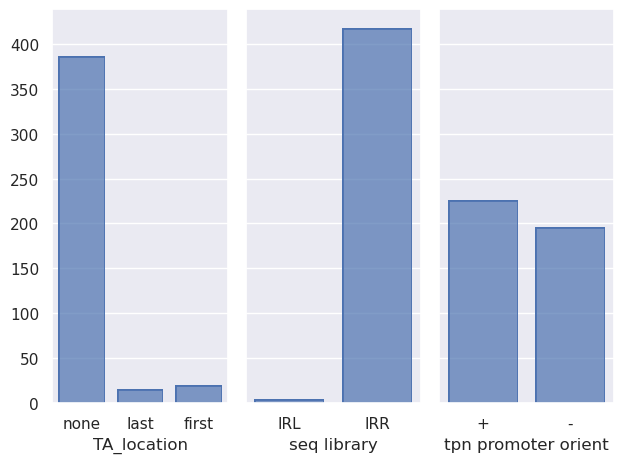

In [80]:
g = (
    so.Plot(inserts_df)
    .add(so.Bar(), so.Count())
    .pair(x=["TA_location", "seq library", "tpn promoter orient"])
)
g.show()

## Now analyze all-files results

In [85]:
from pandas import read_csv, concat

In [ ]:
insertion_dir = Path("/research/labs/immunology/rogerslm/m277102/projects/NetCIS/2020_SB/all_files-insertions")
insert_list = []
for file in insertion_dir.iterdir():
    tmp_df = read_csv(file)
    
    tumor_model, sample_id, tumor_tmp = file.name.split("-")
    tissue_type, lib_tmp = tumor_tmp.split("_")
    library = lib_tmp.split(".")[0]
    
    tmp_df["tumor_model_type"] = tumor_model
    tmp_df["sample_id"] = sample_id
    tmp_df["tissue_type"] = tissue_type
    tmp_df["library"] = library
    
    insert_list.append(tmp_df)
    
inserts_df = concat(insert_list, ignore_index=True)

# make chromsome dict from file

In [3]:
import pandas as pd
chr_dict = {
    "NC_000067.7": "chr1",
    "NC_000068.8": "chr2",
    "NC_000069.7": "chr3",
    "NC_000070.7": "chr4",
    "NC_000071.7": "chr5",
    "NC_000072.7": "chr6",
    "NC_000073.7": "chr7",
    "NC_000074.7": "chr8",
    "NC_000075.7": "chr9",
    "NC_000076.7": "chr10",
    "NC_000077.7": "chr11",
    "NC_000078.7": "chr12",
    "NC_000079.7": "chr13",
    "NC_000080.7": "chr14",
    "NC_000081.7": "chr15",
    "NC_000082.7": "chr16",
    "NC_000083.7": "chr17",
    "NC_000084.7": "chr18",
    "NC_000085.7": "chr19",
    "NC_000086.8": "chrX",
    "NC_000087.8": "chrY",
    "NC_005089.1": "chrM",
}

tmp = pd.DataFrame.from_dict(chr_dict, orient="index")
tmp = tmp.reset_index(drop=False)
display(tmp)
tmp.to_csv("/project/cs-myers/MathewF/projects/Laura-SB-Analysis/NetCIS/toy-data/chrom_mapper.tsv", sep="\t", index=False, header=False)
# tmp.to_csv("/research/labs/immunology/rogerslm/m277102/projects/NetCIS/2020_SB/chrom_mapper.tsv", sep="\t", index=False, header=False)

,index,0
0,NC_000067.7,chr1
1,NC_000068.8,chr2
2,NC_000069.7,chr3
3,NC_000070.7,chr4
4,NC_000071.7,chr5
5,NC_000072.7,chr6
6,NC_000073.7,chr7
7,NC_000074.7,chr8
8,NC_000075.7,chr9
9,NC_000076.7,chr10


In [15]:
df = pd.read_csv("/research/labs/immunology/rogerslm/m277102/projects/NetCIS/2020_SB/chrom_mapper.tsv", sep="\t", header=None)
display(df)

,0,1
0,NC_000067.7,chr1
1,NC_000068.8,chr2
2,NC_000069.7,chr3
3,NC_000070.7,chr4
4,NC_000071.7,chr5
5,NC_000072.7,chr6
6,NC_000073.7,chr7
7,NC_000074.7,chr8
8,NC_000075.7,chr9
9,NC_000076.7,chr10
